In [78]:
library(randomForest)
library(readr)
library(dplyr)
library(rpart)
library(caret)
library(nnet)
library(vip)

data <- read_csv("nsw.csv", show_col_types = FALSE)
categorical_columns <- c(
  "Gender", "Experience", "Industry", "FamilyStatus",
  "Location", "InterpersonalRelationships", "SocialIsolation",
  "EconomicResources", "RemoteWorkCompatability", "Motivation",
  "PhysicalEnvironment", "Wellbeing", "MentalHealth", "PhysicalHealth",
  "Sociability", "ManagingRole", "RemoteWorkExtent",
  "RemoteWorkSupport", "Productivity"
)
numeric_columns <- c(
  "Age", "Commuting", "WorkEfficiency", "Housework", "FamilyTime", "Sleep"
)

data[categorical_columns] <- lapply(data[categorical_columns], as.factor)
data[numeric_columns] <- lapply(data[numeric_columns], as.numeric)
data[numeric_columns] <- lapply(data[numeric_columns], scale)

head(data)
dim(data)

Age,Gender,Experience,Industry,FamilyStatus,Location,InterpersonalRelationships,Commuting,WorkEfficiency,Housework,⋯,Motivation,PhysicalEnvironment,Wellbeing,MentalHealth,PhysicalHealth,Sociability,ManagingRole,RemoteWorkExtent,RemoteWorkSupport,Productivity
"<dbl[,1]>",<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
0.25489190,Male,3,Other Services,Couple with dependent children,Metro,1,-0.61964823,1.3719844,-0.2207096,⋯,2,2,3,3,3,2,No,2,3,3
0.67971175,Male,3,Construction,Couple with no dependent children,Metro,2,-0.26621209,1.3719844,1.5534631,⋯,2,2,2,2,2,2,No,1,2,3
0.08496397,Female,1,Financial and Insurance,Single person,Metro,1,-0.61964823,-0.2026512,0.6663767,⋯,3,3,2,3,2,1,No,3,3,2
1.44438746,Female,2,Health Care and Social Assistance,One parent family with dependent children,Regional,1,0.79409634,-0.2026512,-1.9948822,⋯,1,1,1,3,3,3,Yes,2,2,3
-0.50978381,Male,2,Manufacturing,Couple with dependent children,Metro,2,0.08722406,-0.2026512,1.5534631,⋯,2,2,2,2,2,2,No,2,2,2
0.50978381,Male,3,Public Administration and Safety,Couple with dependent children,Metro,1,0.08722406,-0.2026512,-0.2207096,⋯,3,2,2,3,3,3,Yes,3,2,2


[1] 1420   25

In [79]:
min_class_size <- data %>%
  count(MentalHealth) %>%
  summarise(min_size = min(n)) %>%
  pull(min_size)

# Undersample all classes to the smallest class size
data <- data %>%
  group_by(MentalHealth) %>%
  slice_sample(n = min_class_size) %>%
  ungroup()

table(balanced_data$MentalHealth)


  1   2   3 
155 155 155 

In [80]:
set.seed(123)
train_index <- createDataPartition(data$MentalHealth, p = 0.8, list = FALSE)
train_data <- data[train_index, ]
test_data <- data[-train_index, ]

table(train_data$MentalHealth)
table(test_data$MentalHealth)


  1   2   3 
124 124 124 


 1  2  3 
31 31 31 

In [81]:
model <- multinom(MentalHealth ~ ., data = train_data)
predicted_classes <- predict(model, test_data, type = "class")

conf_matrix <- confusionMatrix(
  factor(predicted_classes, levels = levels(test_data$MentalHealth)),
  test_data$MentalHealth
)
conf_matrix

# weights:  183 (120 variable)


initial  value 408.683771 
iter  10 value 276.044207
iter  20 value 246.991163
iter  30 value 243.728033
iter  40 value 242.846299
iter  50 value 240.992321
iter  60 value 240.442519
iter  70 value 240.413837
iter  80 value 240.349858
iter  90 value 240.265493
iter 100 value 240.008570
final  value 240.008570 
stopped after 100 iterations


Confusion Matrix and Statistics

          Reference
Prediction  1  2  3
         1 19  7  3
         2  6 16  9
         3  6  8 19

Overall Statistics
                                          
               Accuracy : 0.5806          
                 95% CI : (0.4738, 0.6822)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 8.774e-07       
                                          
                  Kappa : 0.371           
                                          
 Mcnemar's Test P-Value : 0.7685          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.6129   0.5161   0.6129
Specificity            0.8387   0.7581   0.7742
Pos Pred Value         0.6552   0.5161   0.5758
Neg Pred Value         0.8125   0.7581   0.8000
Prevalence             0.3333   0.3333   0.3333
Detection Rate         0.2043   0.1720   0.2043
Detection Prevalence   0.3118   0.3333   0.3548
Balanced Accuracy      0.7258   0.6371   0.6935

In [82]:
coeffs <- summary(model)$coefficients

# Average absolute value of coefficients for each feature across classes
feature_influence <- apply(abs(coeffs), 2, mean)

# Rank the features by their average magnitude to find the most influential ones
feature_influence_df <- data.frame(
  Feature = names(feature_influence),
  Importance = feature_influence
)

# Sort features by their importance
feature_influence_df <- feature_influence_df[
  order(-feature_influence_df$Importance),
]
feature_influence_df

,Feature,Importance
,<chr>,<dbl>
IndustryMining,IndustryMining,273.92398744
(Intercept),(Intercept),89.39529142
IndustryConstruction,IndustryConstruction,86.22632672
IndustryManufacturing,IndustryManufacturing,85.49149032
IndustryArts and Recreation,IndustryArts and Recreation,85.36557713
"IndustryElectricity, Gas, Water and Waste","IndustryElectricity, Gas, Water and Waste",85.32705679
IndustryWholesale Trade,IndustryWholesale Trade,85.27502401
IndustryEducation and Training,IndustryEducation and Training,85.21441417
"IndustryAgriculture, Forestry and Fishing","IndustryAgriculture, Forestry and Fishing",85.15438230


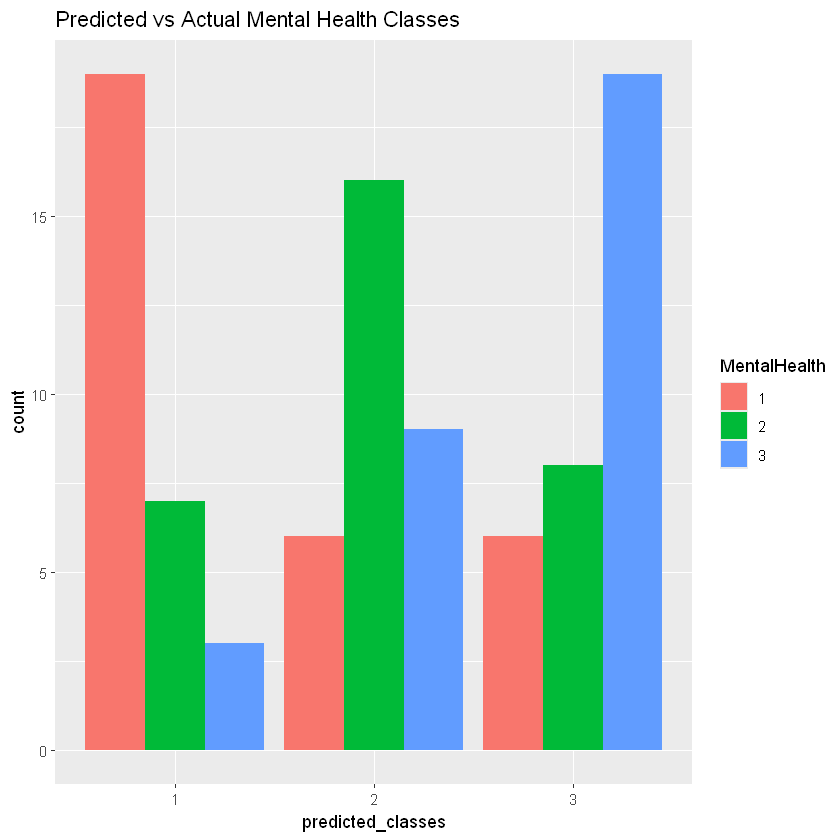

In [83]:
ggplot(data = test_data, aes(x = predicted_classes, fill = MentalHealth)) +
  geom_bar(position = "dodge") +
  labs(title = "Predicted vs Actual Mental Health Classes")

In [84]:
rf_model <- randomForest(MentalHealth ~ ., data = train_data)
rf_predictions <- predict(rf_model, test_data)
rf_conf_matrix <- confusionMatrix(rf_predictions, test_data$MentalHealth)
rf_conf_matrix

Confusion Matrix and Statistics

          Reference
Prediction  1  2  3
         1 18  7  3
         2 11 18  7
         3  2  6 21

Overall Statistics
                                          
               Accuracy : 0.6129          
                 95% CI : (0.5062, 0.7122)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 3.217e-08       
                                          
                  Kappa : 0.4194          
                                          
 Mcnemar's Test P-Value : 0.7612          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.5806   0.5806   0.6774
Specificity            0.8387   0.7097   0.8710
Pos Pred Value         0.6429   0.5000   0.7241
Neg Pred Value         0.8000   0.7719   0.8438
Prevalence             0.3333   0.3333   0.3333
Detection Rate         0.1935   0.1935   0.2258
Detection Prevalence   0.3011   0.3871   0.3118
Balanced Accuracy      0.7097   0.6452   0.7742